Fitting 4 folds for each of 2 candidates, totalling 8 fits

✅ Best Parameters: {'n_neighbors': 5, 'p': 1, 'weights': 'distance'}

Cross-validation F1-macro scores: [0.89733573 0.89924821 0.89543281 0.89105096]
Mean CV F1-macro score: 0.8958

📊 Validation Classification Report:
              precision    recall  f1-score   support

    Magnetic       0.92      0.93      0.93      7135
          NM       0.88      0.86      0.87      4107

    accuracy                           0.91     11242
   macro avg       0.90      0.90      0.90     11242
weighted avg       0.91      0.91      0.91     11242



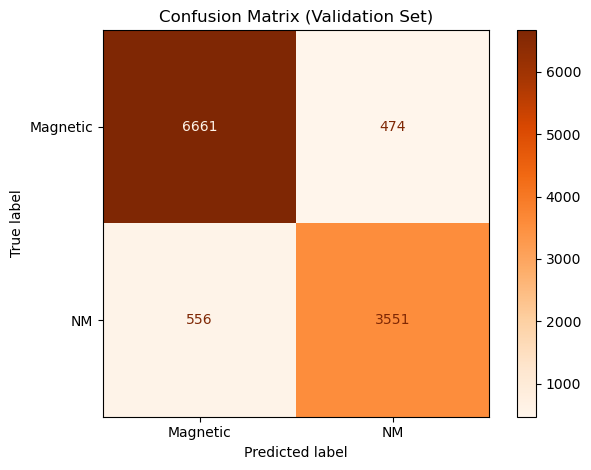


🧪 Test Classification Report:
              precision    recall  f1-score   support

    Magnetic       0.92      0.94      0.93      7135
          NM       0.89      0.86      0.88      4107

    accuracy                           0.91     11242
   macro avg       0.91      0.90      0.91     11242
weighted avg       0.91      0.91      0.91     11242



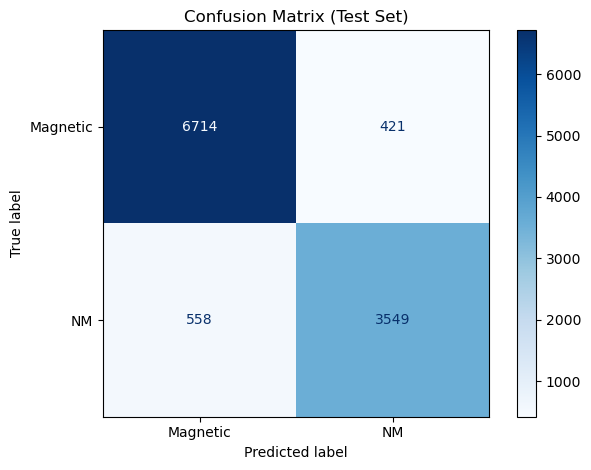


📈 F1-Macro Scores for Overfitting Check:
Training F1-Macro Score:   1.0000
Validation F1-Macro Score: 0.9008
Test F1-Macro Score:       0.9054


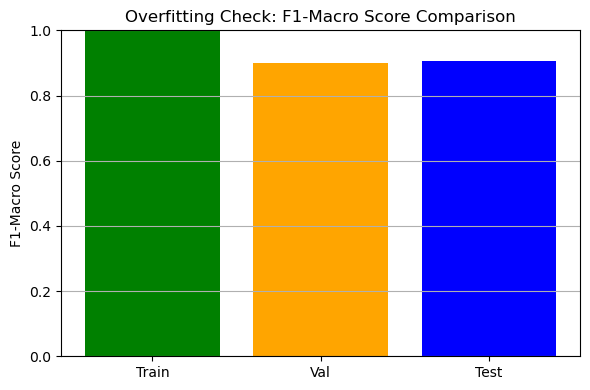

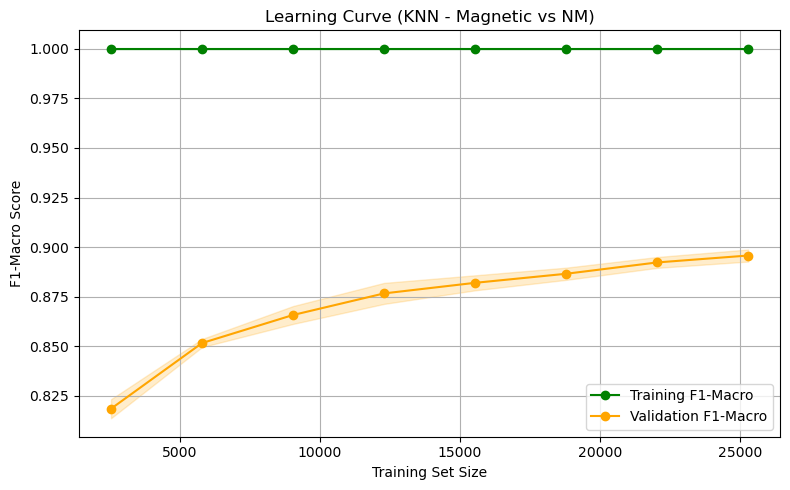

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, GridSearchCV, learning_curve
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.neighbors import KNeighborsClassifier

# === 1. Load CSV ===
df = pd.read_csv("Materials_With_AtLeast_OneMagneticElement.csv")

# === 2. Parse elements column ===
def parse_elements(val):
    if pd.isna(val):
        return []
    return [e.strip().split()[-1] for e in str(val).strip("[]").split(",")]
df["elements"] = df["elements"].apply(parse_elements)

# === 3. Extract crystal system ===
def extract_crystal_system(symmetry_str):
    if pd.isna(symmetry_str):
        return "Unknown"
    match = re.search(r"crystal_system=<CrystalSystem\.\w+: '(\w+)'", str(symmetry_str))
    return match.group(1) if match else "Unknown"
df["crystal_system"] = df["symmetry"].apply(extract_crystal_system)

# === 4. Drop rows with missing values ===
numerical_features = ["cbm", "vbm", "energy_above_hull", "band_gap", "density_atomic",
                      "numberofelements", "volume", "nsites", "density", "efermi", "formation_energy_per_atom"]
df = df.dropna(subset=numerical_features + ["ordering"])

# === 5. Merge FM, FiM, AFM into "Magnetic" ===
df["ordering"] = df["ordering"].replace({"FM": "Magnetic", "FiM": "Magnetic", "AFM": "Magnetic"})

# === 6. One-hot encode elements and crystal system ===
mlb = MultiLabelBinarizer()
element_df = pd.DataFrame(mlb.fit_transform(df["elements"]), columns=mlb.classes_)
crystal_df = pd.get_dummies(df["crystal_system"], prefix="crysys")

# === 7. Combine features ===
X_raw = pd.concat([
    df[numerical_features].reset_index(drop=True),
    element_df.reset_index(drop=True),
    crystal_df.reset_index(drop=True)
], axis=1)

# === 8. Encode binary target ===
le = LabelEncoder()
y = le.fit_transform(df["ordering"])  # Magnetic = 1, NM = 0

# === 9. Feature scaling ===
scaler = StandardScaler()
X = scaler.fit_transform(X_raw)

# === 10. Split into train/val/test ===
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

# === 11. Grid Search ===
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
param_grid = {
    'n_neighbors': [5],
    'weights': ['uniform', 'distance'],
    'p': [1]
}

grid_search = GridSearchCV(
    KNeighborsClassifier(),
    param_grid=param_grid,
    scoring='f1_macro',
    cv=skf,
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)
best_knn = grid_search.best_estimator_
print(f"\n✅ Best Parameters: {grid_search.best_params_}\n")

# === 12. Cross-validation scores ===
cv_scores = cross_val_score(best_knn, X_train, y_train, cv=skf, scoring='f1_macro', n_jobs=-1)
print(f"Cross-validation F1-macro scores: {cv_scores}")
print(f"Mean CV F1-macro score: {cv_scores.mean():.4f}")

# === 13. Validation performance ===
y_pred_val = best_knn.predict(X_val)
print("\n📊 Validation Classification Report:")
print(classification_report(y_val, y_pred_val, target_names=le.classes_))
ConfusionMatrixDisplay(confusion_matrix(y_val, y_pred_val), display_labels=le.classes_).plot(cmap="Oranges", values_format="d")
plt.title("Confusion Matrix (Validation Set)")
plt.tight_layout()
plt.show()

# === 14. Test performance ===
y_pred_test = best_knn.predict(X_test)
print("\n🧪 Test Classification Report:")
print(classification_report(y_test, y_pred_test, target_names=le.classes_))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_test), display_labels=le.classes_).plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (Test Set)")
plt.tight_layout()
plt.show()

# === 15. Overfitting Check ===
y_pred_train = best_knn.predict(X_train)
f1_train = f1_score(y_train, y_pred_train, average='macro')
f1_val = f1_score(y_val, y_pred_val, average='macro')
f1_test = f1_score(y_test, y_pred_test, average='macro')
print("\n📈 F1-Macro Scores for Overfitting Check:")
print(f"Training F1-Macro Score:   {f1_train:.4f}")
print(f"Validation F1-Macro Score: {f1_val:.4f}")
print(f"Test F1-Macro Score:       {f1_test:.4f}")

plt.figure(figsize=(6, 4))
plt.bar(['Train', 'Val', 'Test'], [f1_train, f1_val, f1_test], color=['green', 'orange', 'blue'])
plt.ylabel('F1-Macro Score')
plt.title('Overfitting Check: F1-Macro Score Comparison')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# === 16. Learning Curve ===
train_sizes, train_scores, val_scores = learning_curve(
    estimator=best_knn,
    X=X_train,
    y=y_train,
    cv=skf,
    scoring='f1_macro',
    train_sizes=np.linspace(0.1, 1.0, 8),
    n_jobs=-1
)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, 'o-', label="Training F1-Macro", color="green")
plt.plot(train_sizes, val_mean, 'o-', label="Validation F1-Macro", color="orange")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color="green")
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color="orange")
plt.title("Learning Curve (KNN - Magnetic vs NM)")
plt.xlabel("Training Set Size")
plt.ylabel("F1-Macro Score")
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()
